In [1]:
#downloading the data of google stock for 2 years using yfinance
import yfinance as yf
data = yf.download("GOOGL", start="2021-01-01", end="2025-12-20")
print(data.head())



[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker          GOOGL      GOOGL      GOOGL      GOOGL     GOOGL
Date                                                            
2021-01-04  85.659279  87.463639  84.716898  87.340076  37324000
2021-01-05  86.350067  86.686522  85.201246  85.607675  20360000
2021-01-06  85.498001  86.544598  84.169045  84.375486  46588000
2021-01-07  88.051712  88.224403  85.690547  85.690547  41936000
2021-01-08  89.217407  89.293333  87.400629  88.191657  35484000


In [2]:
#apply ARIMA to close price as it is less noisy compare to High/Low
series=data["Close"]["GOOGL"]
print(series.head(15))
#Preprocessing
#1 check if all the values are numeric--->done as dtype is float
print(series.dtype)



Date
2021-01-04    85.659279
2021-01-05    86.350067
2021-01-06    85.498001
2021-01-07    88.051712
2021-01-08    89.217407
2021-01-11    87.155968
2021-01-12    86.220039
2021-01-13    86.707367
2021-01-14    85.896996
2021-01-15    85.733215
2021-01-19    88.554405
2021-01-20    93.298561
2021-01-21    93.501030
2021-01-22    93.918381
2021-01-25    94.003731
Name: GOOGL, dtype: float64
float64


In [3]:
#2 fixing regularity ie deal with the missing value of  saturdays and sundays
series=series.asfreq("B")
series=series.ffill()#fowrward filling as close prices won't change on saturday and sundays
series.index.inferred_freq
print(series.head(15))


Date
2021-01-04    85.659279
2021-01-05    86.350067
2021-01-06    85.498001
2021-01-07    88.051712
2021-01-08    89.217407
2021-01-11    87.155968
2021-01-12    86.220039
2021-01-13    86.707367
2021-01-14    85.896996
2021-01-15    85.733215
2021-01-18    85.733215
2021-01-19    88.554405
2021-01-20    93.298561
2021-01-21    93.501030
2021-01-22    93.918381
Freq: B, Name: GOOGL, dtype: float64


In [4]:
#3 check stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(series)

print("ADF Statistic:", result[0])
print("p-value:", result[1])
# as p value is large (as expected) this suggests the series is non stationary
#further we go by differencing

ADF Statistic: 1.5120926417831233
p-value: 0.9975683434979727


In [5]:
#using 1 difference ie d=1
diff_series = series.diff().dropna()
result1=adfuller(diff_series)
print("ADF Statistic:", result1[0])
print("p-value:", result1[1])

ADF Statistic: -9.368198561797357
p-value: 7.500285031831001e-16


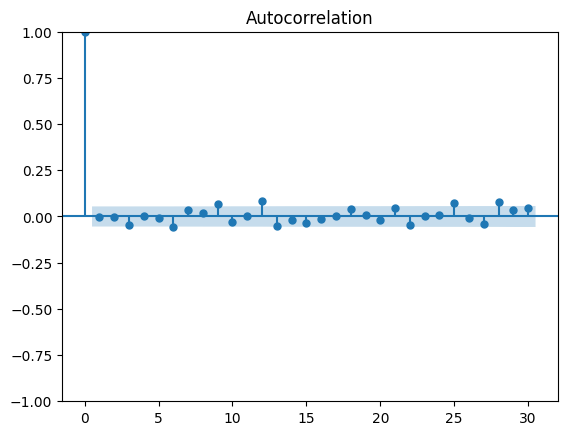

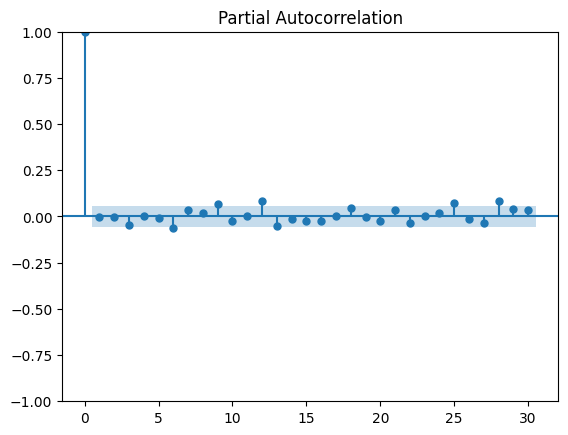

In [6]:
#using pacf and acf plots to find p and q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(diff_series, lags=30)
plt.show()

plot_pacf(diff_series, lags=30)
plt.show()


In [7]:
#as only only band at lag 0 crosses the 95% confidence interval we ignore it
# no other lag crosses the band so we can't directly give the AR(p) and MA(q)
#creating train test split (keeping in mind that chronological order is maintained
n = len(diff_series)
train_size = int(0.8 * n)

train = diff_series.iloc[:train_size]
test = diff_series.iloc[train_size:]



print("Total observations:", n)
print("Train size:", len(train))
print("Test size:", len(test))

print("\nTrain period:", train.index.min(), "to", train.index.max())
print("Test period:", test.index.min(), "to", test.index.max())


Total observations: 1294
Train size: 1035
Test size: 259

Train period: 2021-01-05 00:00:00 to 2024-12-23 00:00:00
Test period: 2024-12-24 00:00:00 to 2025-12-19 00:00:00


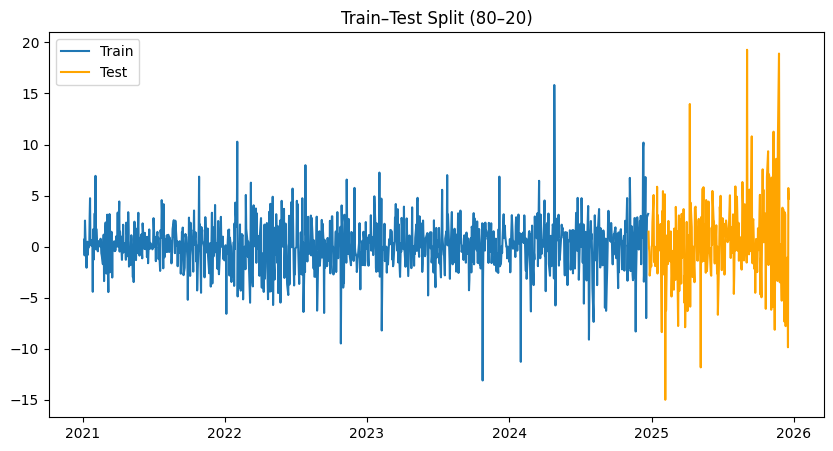

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.legend()
plt.title("Train–Test Split (80–20)")
plt.show()

In [9]:
train_orig = series.iloc[:train_size]
train_orig = train_orig.asfreq("B").dropna()
test_orig = series.iloc[:train_size]
test_orig = test_orig.asfreq("B").dropna()

In [10]:
# trying different order of (p,1,q) in ARIMA model and selecting one with lowest AIC
#(1,1,1),(1,1,0),(0,1,1)
from statsmodels.tsa.arima.model import ARIMA

orders = [(1,1,0), (0,1,1), (1,1,1),(0,1,0)]#I =0 as we are fitting model on diff_series
results = {}

for order in orders:
    model = ARIMA(train_orig, order=order)
    fit = model.fit()
    results[order] = fit.aic

for order, aic in results.items():
    print(f"ARIMA{order}  AIC = {aic:.2f}")

ARIMA(1, 1, 0)  AIC = 4761.22
ARIMA(0, 1, 1)  AIC = 4761.21
ARIMA(1, 1, 1)  AIC = 4763.28
ARIMA(0, 1, 0)  AIC = 4759.29


C:\Users\prana\PyCharmMiscProject\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  GOOGL   No. Observations:                 1035
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2378.643
Date:                Mon, 05 Jan 2026   AIC                           4759.287
Time:                        23:46:45   BIC                           4764.228
Sample:                    01-04-2021   HQIC                          4761.162
                         - 12-20-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.8298      0.145     40.155      0.000       5.545       6.114
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               779.81
Prob(Q):                              0.83   Pr

<Axes: title={'center': 'Residuals of Final ARIMA Model'}, xlabel='Date'>

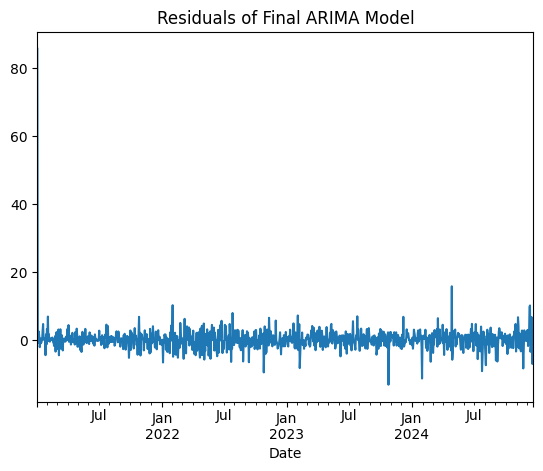

In [11]:
#lowest aic is for (0,0,0)
#therefore our order for ARIMA model is (0,1,0)
#we train and test our model
from statsmodels.tsa.arima.model import ARIMA

final_order = (0, 1, 0)   # as we are fitting on diff_series

final_model = ARIMA(train_orig, order=final_order)
final_fit = final_model.fit()

print(final_fit.summary())
final_fit.resid.plot(title="Residuals of Final ARIMA Model")


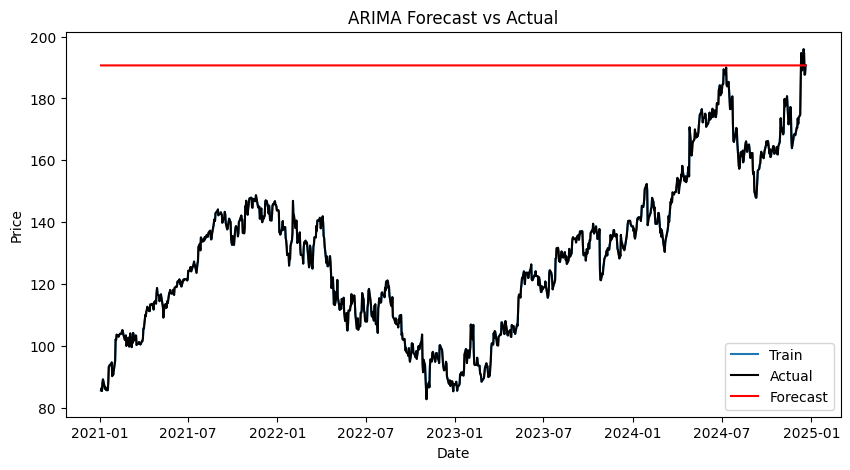

In [12]:
n_test = len(test_orig)

forecast = final_fit.forecast(steps=n_test)
forecast.index = test_orig.index

plt.figure(figsize=(10,5))
plt.plot(train_orig, label="Train")
plt.plot(test_orig, label="Actual", color="black")
plt.plot(forecast, label="Forecast", color="red")

plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
rmse = np.sqrt(mean_squared_error(test_orig, forecast))
mae = mean_absolute_error(test_orig, forecast)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 66.54096583218994
MAE: 61.63422154965608


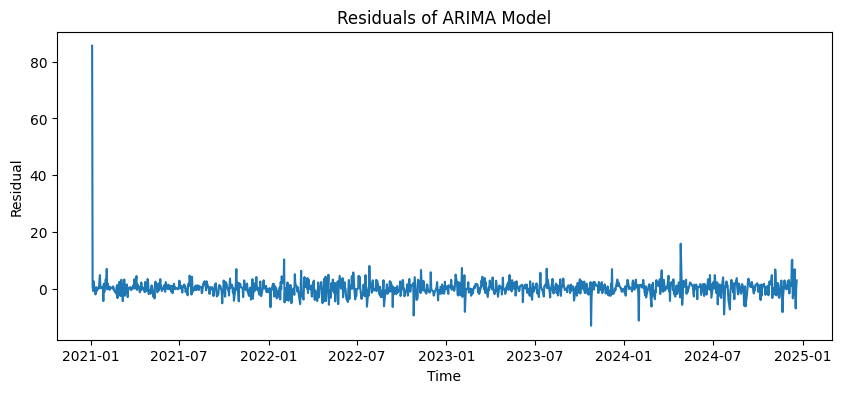

In [14]:
#plotting residuals
residuals = final_fit.resid


plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()

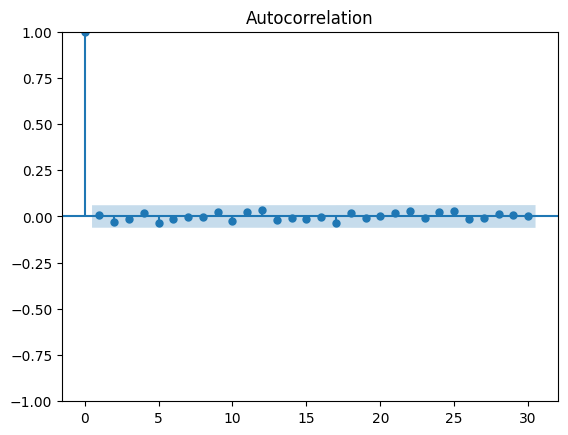

In [15]:
#plotting acf residuals
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=30)
plt.show()
